Epoch 0 | D Loss: 0.2956 | G Loss: 2.5246
Epoch 1 | D Loss: 0.3618 | G Loss: 0.8622
Epoch 2 | D Loss: 0.2741 | G Loss: 2.5250
Epoch 3 | D Loss: 0.2859 | G Loss: 2.3793
Epoch 4 | D Loss: 0.5607 | G Loss: 0.4603
Epoch 5 | D Loss: 0.5908 | G Loss: 0.4385
Epoch 6 | D Loss: 0.3918 | G Loss: 2.3130
Epoch 7 | D Loss: 0.3893 | G Loss: 2.6148
Epoch 8 | D Loss: 0.6342 | G Loss: 0.4241
Epoch 9 | D Loss: 0.6510 | G Loss: 0.4060
Epoch 10 | D Loss: 0.5864 | G Loss: 2.3586
Epoch 11 | D Loss: 0.5304 | G Loss: 1.7970
Epoch 12 | D Loss: 0.4960 | G Loss: 1.6619
Epoch 13 | D Loss: 0.4837 | G Loss: 1.9885
Epoch 14 | D Loss: 0.4469 | G Loss: 1.8031
Epoch 15 | D Loss: 0.4111 | G Loss: 1.0184
Epoch 16 | D Loss: 0.6002 | G Loss: 0.7117
Epoch 17 | D Loss: 0.6115 | G Loss: 1.8043
Epoch 18 | D Loss: 0.6615 | G Loss: 0.4576
Epoch 19 | D Loss: 0.5626 | G Loss: 1.0105


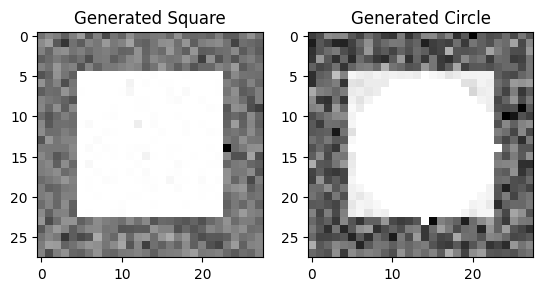

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- 1. Synthetic Data Creation ---
class ShapeDataset(Dataset):
    def __init__(self, num_samples=10000):
        self.images = []
        self.labels = []
        for _ in range(num_samples):
            img = np.zeros((28, 28), dtype=np.float32)
            label = np.random.randint(0, 2)  # 0: Square, 1: Circle
            if label == 0:
                cv2.rectangle(img, (5, 5), (22, 22), 1.0, -1)
            else:
                cv2.circle(img, (14, 14), 9, 1.0, -1)
            self.images.append(img[np.newaxis, :, :]) # Add channel dim
            self.labels.append(label)

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]), torch.tensor(self.labels[idx])

# --- 2. Model Architectures ---
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        return self.model(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + 28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], 1)
        return self.model(x)

# --- 3. Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
n_classes = 2
gen = Generator(n_classes, latent_dim).to(device)
disc = Discriminator(n_classes).to(device)

dataset = ShapeDataset()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

optimizer_G = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()

# --- 4. Training Loop ---
epochs = 20
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]
        imgs, labels = imgs.to(device), labels.to(device)

        # Labels for Real/Fake
        real_target = torch.ones(batch_size, 1).to(device)
        fake_target = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        gen_imgs = gen(z, gen_labels)
        validity = disc(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, real_target)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(disc(imgs, labels), real_target)
        fake_loss = adversarial_loss(disc(gen_imgs.detach(), gen_labels), fake_target)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# --- 5. Visualizing Results ---
def plot_results(gen):
    z = torch.randn(2, latent_dim).to(device)
    labels = torch.tensor([0, 1]).to(device) # Ask for a square (0) and a circle (1)
    gen_imgs = gen(z, labels).detach().cpu().numpy()

    plt.subplot(1, 2, 1); plt.imshow(gen_imgs[0, 0], cmap='gray'); plt.title("Generated Square")
    plt.subplot(1, 2, 2); plt.imshow(gen_imgs[1, 0], cmap='gray'); plt.title("Generated Circle")
    plt.show()

plot_results(gen)

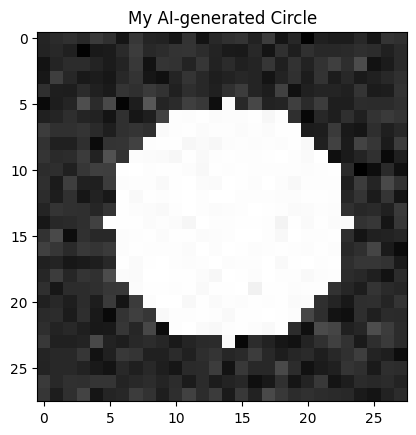

Generator(
  (label_emb): Embedding(2, 2)
  (model): Sequential(
    (0): Linear(in_features=102, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Tanh()
  )
)

In [7]:
# 1. Put the generator in evaluation mode
gen.eval()

with torch.no_grad(): # This saves memory by not calculating gradients
    z = torch.randn(1, 100).to(device)
    label = torch.tensor([1]).to(device) # 1 is Circle
    generated_img = gen(z, label)

# 2. Plot the result
plt.imshow(generated_img.detach().cpu().squeeze(), cmap='gray')
plt.title("My AI-generated Circle")
plt.show()

# 3. (Optional) Switch back to train mode if you plan to keep training
gen.train()